In [ ]:
import os
import numpy as np
import matplotlib
# VSCode環境で別ウィンドウを表示するためにTkAggバックエンドを指定
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import umap

c:\Users\Yoshi\anaconda3\envs\GAN-Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

c:\Users\Yoshi\anaconda3\envs\GAN-Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Yoshi\anaconda3\envs\GAN-Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


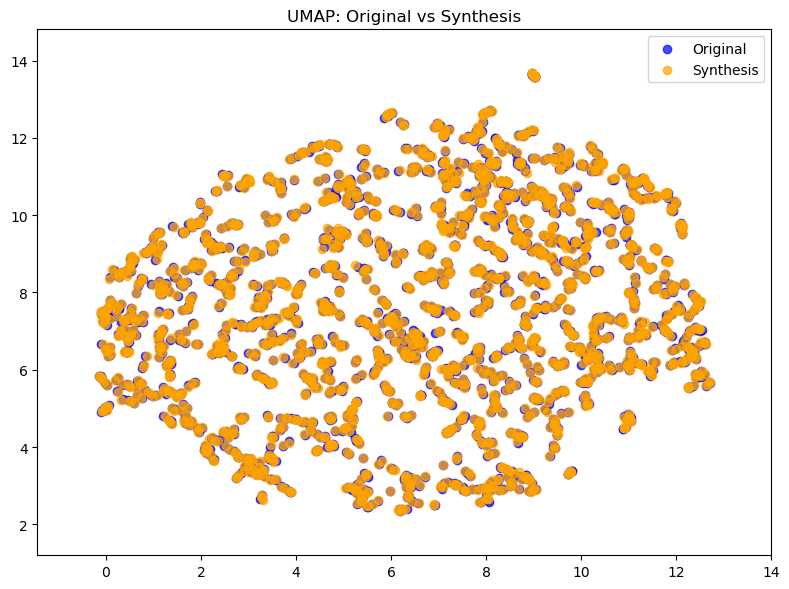

In [ ]:
# === 1) 画像フォルダの特徴量抽出関数 ===
def extract_features_from_folder(folder_path, model, target_size=(224, 224)):
    features = []
    file_names = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_name.lower().endswith(('png', 'jpg', 'jpeg', 'tif')):
            # 画像を読み込む
            img = load_img(file_path, target_size=target_size)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            # 特徴量を抽出
            feature = model.predict(img_array, verbose=0)
            features.append(feature.flatten())
            file_names.append(file_name)
    return np.array(features), file_names

# === 2) ResNet50モデル（全結合層を除外したもの）をロード ===
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# === 3) original と synthesis のフォルダパスを設定 ===
folder_paths = {
    "original": "./original",
    "synthesis": "./synthesis"
}

# === 4) 各フォルダーから特徴量とファイル名を抽出 ===
features = {}
file_names_dict = {}
for folder_name, folder_path in folder_paths.items():
    feats, fnames = extract_features_from_folder(folder_path, model)
    features[folder_name] = feats
    file_names_dict[folder_name] = fnames

# 全ファイルパスのリストを作成（特徴量の結合順序と一致させる）
all_file_paths = []
for folder_name in folder_paths:
    for file_name in file_names_dict[folder_name]:
         all_file_paths.append(os.path.join(folder_paths[folder_name], file_name))

# === 5) 全特徴量を結合してUMAPで次元削減 ===
all_features = np.vstack([features[name] for name in folder_paths])
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embedding = reducer.fit_transform(all_features)

# === 6) 各フォルダーのインデックスを取得 ===
indices = {}
start = 0
for folder_name, feats in features.items():
    end = start + len(feats)
    indices[folder_name] = slice(start, end)
    start = end

# === 7) プロット範囲を事前計算しておく ===
margin = 0.1  # 範囲に余裕を持たせる割合
x_min, x_max = umap_embedding[:, 0].min(), umap_embedding[:, 0].max()
y_min, y_max = umap_embedding[:, 1].min(), umap_embedding[:, 1].max()

x_range = x_max - x_min
y_range = y_max - y_min

x_min -= margin * x_range
x_max += margin * x_range
y_min -= margin * y_range
y_max += margin * y_range

# === クリックイベントハンドラを生成するファクトリ関数 ===
def create_on_click(allowed_indices):
    def on_click(event):
        if event.inaxes is None:
            return
        x_click, y_click = event.xdata, event.ydata
        # クリック対象の点のみで距離を計算
        subset_embedding = umap_embedding[allowed_indices]
        distances = np.sqrt((subset_embedding[:, 0] - x_click)**2 + (subset_embedding[:, 1] - y_click)**2)
        min_idx = np.argmin(distances)
        min_distance = distances[min_idx]
        # クリックの許容範囲（データ座標系での閾値）
        tol = 0.05 * max(x_range, y_range)
        if min_distance < tol:
            global_index = allowed_indices[min_idx]
            file_path = all_file_paths[global_index]
            try:
                # 画像をグレースケールで読み込む
                img = Image.open(file_path).convert('L')
            except Exception as e:
                print(f"画像の読み込みに失敗しました: {file_path}\n{e}")
                return
            # 別ウィンドウで画像をグレースケールで表示
            fig_img, ax_img = plt.subplots()
            ax_img.imshow(np.array(img), cmap='gray')
            ax_img.axis('off')
            fig_img.suptitle(file_path)
            plt.show()
        else:
            print("クリック位置に近い点が見つかりませんでした。")
    return on_click

# === 8a) Original vs Synthesis をプロットする関数（クリックイベント追加） ===
def plot_fixed_range_both(embedding, indices, title, save_path):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # originalは青
    idx_original = indices["original"]
    ax.scatter(
        embedding[idx_original, 0], embedding[idx_original, 1],
        label="Original", color="blue", alpha=0.7
    )

    # synthesisはオレンジ
    idx_synthesis = indices["synthesis"]
    ax.scatter(
        embedding[idx_synthesis, 0], embedding[idx_synthesis, 1],
        label="Synthesis", color="orange", alpha=0.7
    )

    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend()
    fig.tight_layout()

    # すべての点を対象にクリックイベントを接続
    allowed_indices = np.arange(len(umap_embedding))
    fig.canvas.mpl_connect('button_press_event', create_on_click(allowed_indices))

    # PNGファイルとして保存
    fig.savefig(save_path, dpi=300)
    plt.show()
    plt.close(fig)

# === 8b) Original のみをプロットする関数（クリックイベント追加） ===
def plot_fixed_range_original_only(embedding, indices, title, save_path):
    fig, ax = plt.subplots(figsize=(8, 6))

    # originalのみプロット
    idx_original = indices["original"]
    ax.scatter(
        embedding[idx_original, 0], embedding[idx_original, 1],
        label="Original", color="blue", alpha=0.7
    )

    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend()
    fig.tight_layout()

    # クリック対象は「original」の点のみ
    allowed_indices = np.arange(indices["original"].start, indices["original"].stop)
    fig.canvas.mpl_connect('button_press_event', create_on_click(allowed_indices))

    # PNGファイルとして保存
    fig.savefig(save_path, dpi=300)
    plt.show()
    plt.close(fig)

# === 9) プロットの実行（2種類） ===
plot_fixed_range_both(
    umap_embedding,
    indices,
    "UMAP: Original vs Synthesis (Click a point to view image)",
    "umap_original_vs_synthesis.png"
)

plot_fixed_range_original_only(
    umap_embedding,
    indices,
    "UMAP: Only Original (Click a point to view image)",
    "umap_original_only.png"
)
